#Importing required libraries

In [54]:
import cv2
import numpy as np
from skimage import io, color
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from sklearn.metrics.pairwise import euclidean_distances
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
import os

#Functions for Feature Extraction

In [55]:
# Function to extract color histograms for each channel (RGB)
def extract_color_histogram(image):
    if image is None or len(image.shape) != 3 or image.shape[2] != 3:
        raise ValueError("Invalid image. Please check the image path and format.")

    hist_r = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist_g = cv2.calcHist([image], [1], None, [256], [0, 256])
    hist_b = cv2.calcHist([image], [2], None, [256], [0, 256])
    return np.concatenate([hist_r, hist_g, hist_b]).flatten()

# Function to extract Local Binary Patterns (LBP) texture descriptor
def extract_lbp(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray_image, 8, 1, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
    return hist

# Function to extract Gray-Level Co-occurrence Matrix (GLCM) texture descriptor
def extract_glcm(image):
    gray_image = color.rgb2gray(image)
    glcm = graycomatrix((gray_image * 255).astype(np.uint8), [5], [0], 256, symmetric=True, normed=True)
    properties = ['contrast', 'homogeneity', 'energy', 'correlation']
    return np.hstack([graycoprops(glcm, prop).ravel() for prop in properties])

# Function to extract CNN features using VGG16
def extract_cnn_features(image, model):
    image = cv2.resize(image, (224, 224))
    image = preprocess_input(image)
    image = np.expand_dims(image, axis=0)
    features = model.predict(image)
    return features.flatten()

# Function to extract shape features using Hu Moments
def extract_hu_moments(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    moments = cv2.HuMoments(cv2.moments(gray_image)).flatten()
    return moments


#Function Definitions for Similarity Calculation and Image Database Handling

In [56]:
# Function to calculate Euclidean distance between two feature vectors
def calculate_similarity(feature_vector1, feature_vector2):
    return euclidean_distances([feature_vector1], [feature_vector2])[0][0]

# Load the image database (folder containing images)
def load_image_database(folder_path):
    image_paths = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if filename.endswith('.jpg')]
    image_database = []
    for image_path in image_paths:
        image = cv2.imread(image_path)
        image_database.append(image)
    return image_database


#Image Retrieval Function with Pre-loaded VGG16 Model

In [57]:
# Preload the VGG16 model to avoid loading it repeatedly
vgg_model = VGG16(weights='imagenet', include_top=False)

def image_retrieval(query_content, image_database_folder, model, k=5):
    if query_content is None or len(query_content.shape) != 3 or query_content.shape[2] != 3:
        raise ValueError("Invalid query image. Please check the image format.")

    query_color_hist = extract_color_histogram(query_content)
    query_lbp = extract_lbp(query_content)
    query_glcm = extract_glcm(query_content)
    query_cnn_features = extract_cnn_features(query_content, model)
    query_hu_moments = extract_hu_moments(query_content)

    image_database = load_image_database(image_database_folder)
    database_features = []

    for image in image_database:
        color_hist = extract_color_histogram(image)
        lbp = extract_lbp(image)
        glcm = extract_glcm(image)
        cnn_features = extract_cnn_features(image, model)
        hu_moments = extract_hu_moments(image)

        feature_vector = np.hstack([color_hist, lbp, glcm, cnn_features, hu_moments])
        database_features.append(feature_vector)

    query_feature_vector = np.hstack([query_color_hist, query_lbp, query_glcm, query_cnn_features, query_hu_moments])
    similarity_scores = [calculate_similarity(query_feature_vector, db_feature) for db_feature in database_features]
    top_k_indices = np.argsort(similarity_scores)[:k]
    retrieved_images = [image_database[idx] for idx in top_k_indices]
    # Return both the images and the scores
    return retrieved_images, similarity_scores, top_k_indices


In [58]:
def display_images_with_scores(query_image, retrieved_images, similarity_scores):
    # Display query image
    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB))
    plt.title("Query Image")
    plt.axis('off')

    # Display retrieved images
    plt.figure(figsize=(10, 10))
    for i, (image, score) in enumerate(zip(retrieved_images, similarity_scores), start=1):
        plt.subplot(1, len(retrieved_images), i)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f"Score: {score:.2f}")
        plt.axis('off')
    plt.show()


# Example Usage

1/1 [==============================] - 1s 825ms/step


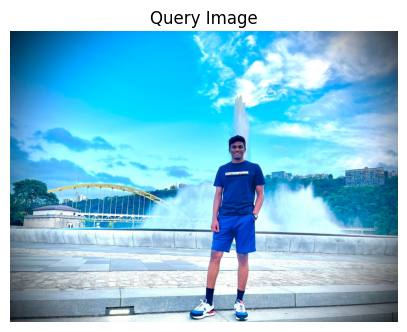

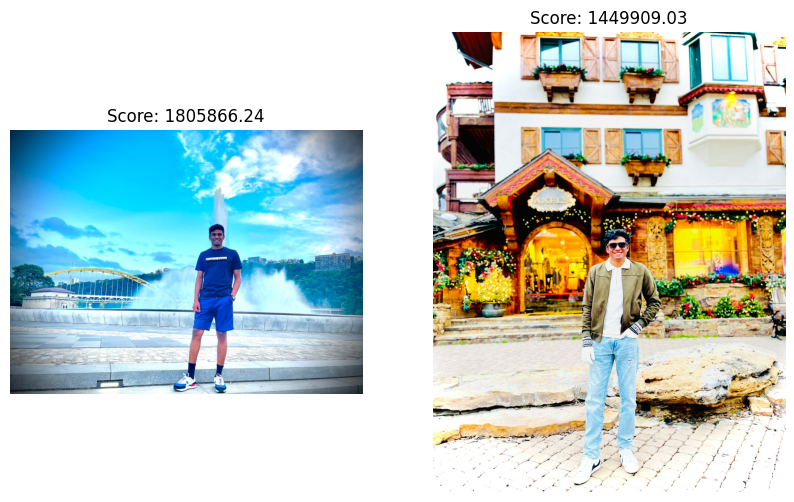

In [64]:
import matplotlib.pyplot as plt

query_image_path = "/content/objects/M1.jpg"
image_database_folder = "/content/objects"
k = 5

query_image = cv2.imread(query_image_path)
try:
    retrieved_images, similarity_scores, top_k_indices = image_retrieval(query_image, image_database_folder, vgg_model, k=2)
    display_images_with_scores(query_image, retrieved_images, similarity_scores)



except ValueError as e:
    print("Error during image retrieval:", str(e))
except Exception as e:
    print("An unexpected error occurred:", str(e))
